# OpenStreetMap Data Case Study

## Map Area
Falmouth and surrounds, Cornwall, United Kingdom
- https://en.wikipedia.org/wiki/Cornwall
- https://en.wikipedia.org/wiki/Falmouth,_Cornwall
- https://www.openstreetmap.org/node/29285363#map=11/50.1552/-5.0688

I live in Falmouth a historic area in the SW UK.  Falmouth is not a large city so I had to zoom out the map to cover surrouding areas as well, so the osm map size was over 50Mb.  This took in some of the surrounding towns and villages which are part of a larger city to the north of Falmouth called Truro.


## Processing and Auditing
A map of the falmouth area was downloaded, python code given in the project prep section of the audacity website was used downsample the data and to make it a more manageable size for investigation.  A considerable amount of time was spent looking at the generated data to see if there were any problems, some of the problems are discussed below

## Problems with the dataset
After some initial investigation of the dataset some of the problems encountered with the data are discussed below:
- Over­abbreviated street names *(“Newquay St.”)*
- Problematic characters appearing in tag 'k'
- Symbols appearing in the tag values which require further processing, in the following format: 
	```XML
	 <tag k="addr:street:name" v="Lincoln"/> 
	```

### Over­abbreviated Street Names
With downsampled data and before import into SQL, tools such as sublime were used investigate the downsampled data for possible problems, several issues were found with street names not being consistently abbreviated.  This was solved using python functions.  I iterated over each word in an address and corrected to a set mapping in falmouth_data_audit.py:
```python
def update_addr_street_(name, mapping): 
  words = name.split()
  for w in range(len(words)):
    if words[w] in mapping:
      if words[w].lower() not in expected and w > 0:
        # For example 'St Mawes St.' becomes 'St Mawes Street'
        words[w] = mapping[words[w]]
        name = " ".join(words)
  return name
```
The first word  was skipped as it is very common in Cornwall to see such names as (“St Mawes St.”) where the first 'St' is an abbreviation of 'Saint' 

### Problematic characters

To overcome tag values that contained words and phrases of no sense, regular expressions were employed such as:  
```python
problem_chars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

```
When the tags were processed, the attributes were checked against the regex and ignored if a match was found:

```python
if problem_chars.search(tag.attrib['k']):
            continue
```
        

### Further processing of tag values
During audit, it was found that many entries had more than one colon(:) value describing tag 'k' values.  It is important for consistency in the SQl databse therefore if the tag "k" value contained a ":" the characters before  ":" were set as the tag type and characters after the ":" were set as the tag key.  If there was additional ":" in the "k" value they were ignored and kept as part of the tag key. For example:
```xml
  <tag k="addr:street:name" v="Lincoln"/>
```
  was turned into
```python
  {'id': 12345, 'key': 'street:name', 'value': 'Lincoln', 'type': 'addr'}
```

the 'type' value was set as either characters before the colon in the tag "k" value or "regular" if a colon was not present.  A code extract from data_falmouth_audit.py to process these tags values is shown below:
```python
lower_colon = re.compile(r'^([a-z|_])+:([a-z|_])+')

colon_k=lower_colon.search(tag.attrib['k'])

if colon_k: #colon_k is not None
    res = tag.attrib['k'].split(':')
    if len(res) < NUM_COLONS: #only one colon
        dic['key'], dic['type'] = (res[1],'regular')
    else: 
        dic['key'],dic['type'] = (res[1] + ':' + res[2], res[0])
else: 
     dic['key'],dic['type']=(attributes['k'],'regular')
```





After auditing the data, the python code was executed and csv files were produced and checked against the udacity supplied schema.py for data integrity.  By using the sqlite3 python library a database file falmouth.db and a suitable schema were generated, the schema was based on the udacity supplied file data_wrangling_schema.sql  I initially had difficulty loading the generated csv files into the database but after spending considerable time on the udacity forums and other websites, I was able to succssfully load the database with the correct table information using python, a code extract is show below: 
```python
with open('ways_nodes.csv','rb') as fin:
 dr = csv.DictReader(fin) # comma is default delimiter
 to_db =[(i['id'].decode('utf-8'),i['node_id'].decode('utf-8'),i['position'].decode('utf-8'),)for i in dr]

cur.executemany("INSERT INTO ways_nodes(id,node_id,position) VALUES (?, ?, ?);", to_db)

# commit the changes
conn.commit()

```
After investigation and auditing the sizes of the final files used are shown below:

### File sizes
```
falmouth.osm ......... 50.9 MB
falmouth.db .......... 26.2 MB
nodes.csv .............20.2 MB
nodes_tags.csv ........ 0.75 MB
ways.csv .............. 1.2 MB
ways_tags.csv ......... 1.6 MB
ways_nodes.cv ......... 6.7 MB  
```  

## Data Investigation
I then moved onto the SQL section of the assignment.  I found sql on the command line cumbersome so i downloaded a free tool 'DB Browser for SQlite' which was more user friendly GUI based system. This section contains results of investigating the dataset in sqlite.

### Number of nodes
```sql
SELECT COUNT(*) FROM nodes;
241170

```

### Number of ways

```sql
SELECT COUNT(*) FROM ways;
19914
```

### Number of unique users

``` sql
SELECT COUNT(DISTINCT(e.uid))
FROM (SELECT uid FROM nodes UNION all SELECT uid FROM ways) e;
SELECT
415
```

### Top 10 contirbuting users
```sql
SELECT e.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION all SELECT user FROM ways) e
GROUP BY e.user
ORDER BY num DESC
limit 10;
```

```sql
The Maassen Mapper 34739
UniEagle           32598 
Sailor Steve       25028
Chris Parker       19638
wh68               15198
KB_MTB             11760
Ian Cann           10272
_01706             8698
duncaninnes        8571
Maddog Battie      8432

```

### Top 10 appearing amenities
```sql 
SELECT value, COUNT(*) as num
FROM nodes_tags
WHERE key = 'amenity'
GROUP BY value
ORDER BY num DESC
limit 10;
```
```sql
bench              140
post_box           111
pub                86
place_of_worship   84
parking            59
cafe               47
post_office        43
restaurant         41
toilets            40
waste_basket       39
```

### Cornish Language and Place Names
Falmouth is in the county of Cornwall.  The language originally spoken in Cornwall before Germanic invaders is known as Cornish:
- https://en.wikipedia.org/wiki/Cornish_language

There are many people locally who are trying to increase the visibility of the ancient cornish language and culture. Many places locally still have cornish language names or their names descended from the Cornish language, example Porth (port), Pen (end or head) and Bos/Bod (home).  We can see this from the database:  

```sql
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) tags
WHERE tags.value LIKE 'Pen%'
GROUP BY tags.value
ORDER BY count DESC
LIMIT 10;
```
```sql
Penberthy Road   18
Pennance Road    16
Pendarves Road   15
Pendarves Street 12
Penventon View   9
Pendeen Road     8
Penryn           8
Penware Parc     8
Penzance Road    7
Penair School    6
```


### Most popular food types
```sql
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='cuisine'
GROUP BY nodes_tags.value
ORDER BY num DESC;
```
```sql
chinese         5
indian          3
fish_and_chips  2
fish            1
italian         1
portugese       1
regional        1
```

### Most popular religion
```sql
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='place_of_worship') i
ON nodes_tags.id=i.id
WHERE nodes_tags.key='religion'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 1;
```
```sql
christian 29
```

[logo]: https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 2"


## Suggestions for improvement
To increase the visibilty of the indigienous cornish language, many roadsigns have dual language labels.  The two examples below, show street names local to me _Fordh Albany (Albany Road)_ and _Rosvalas Trelawney (Trelawney Road)_.

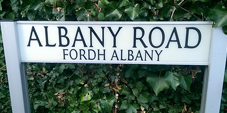

In [18]:
from IPython.display import Image
Image(filename='Albany1.png')

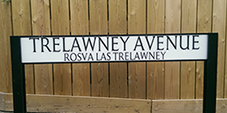

In [19]:
from IPython.display import Image
Image(filename='Trelawney1.png')

Tags with the label 'name' are usually given in the local language, in this case english.  It seems a good idea to add this data to OSM, though its likely only the English name would be used:

-http://wiki.openstreetmap.org/wiki/Multilingual_names#Cornwall

I have discovered it is possible to add a cornish translation.  The format is:
```xml
name=English Street, and name:kw=Cornish Translation
```
This means adding a name:kw, tag but also a volunteer would be required to edit the entry.  So for example Albany road above could have two entries:
```html
name=Albany Road, and name:kw=Fordh Albany
```

## Summary
Data from Open Street Map has been processed and audited and input to a sql databse for query.  Several features in the locale of Falmouth. Cornwall, UK have been displayed.  Suggestions for improving the Open street Map have been discussed.


### Miscellaneous
In compiling this project the following languages and tools were used: Python, SQL, DB Browser for SQLite, command line, xml, sublime and ipython notebook.  This report was compiled using markdown in ipython notebook, it was then downloaded as html.



#### Meur Ras (Thank you!)